In [1]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import warnings; warnings.filterwarnings("ignore")

In [ ]:
# change with your path of data_eurec4a dir
path = '/venus/matteo/data_eurec4a/' 

In [2]:
minlon = -60.; maxlon = -51.
minlat = 0.; maxlat = 17.
level = 33

In [7]:
GP = np.loadtxt(path + 'data/GP_day_levels.txt')
GP = GP[:level]

In [4]:
# PERC DISTRIBUTION
path_bindist_fullfield = path + 'data/perc_dist_daily/fullfield/'
pdist_PBLH_dsst_day = np.loadtxt(path_bindist_fullfield + 'pdist_PBLH_dsst_day.txt')
from metpy.units import units
from metpy.calc import height_to_pressure_std
pdist_P_dsst_day = height_to_pressure_std(pdist_PBLH_dsst_day*units.meter)
PBLH_P = np.mean(pdist_P_dsst_day)

In [5]:
# find data
path = path + 'data/Eureca_vertical_profiles/'
T_z = np.load(path + 'T_z_day.npy')
qvapor_z = np.load(path + 'qvapor_z_day.npy')
qcloud_z = np.load(path + 'qcloud_z_day.npy')
rh_z = np.load(path + 'rh_z_day.npy')
N2_z = np.load(path + 'N2_z_day.npy')
Utot_z = np.load(path + 'Utot_z_day.npy')

In [9]:
# find theta profile
wrf_files =  path + 'data/data_day1.nc'
# fname_list = sorted(glob.glob(wrf_files + '*'))
# open data
# ds = xr.open_mfdataset(fname_list, concat_dim='Time', combine='nested', chunks='auto')
ds = xr.open_dataset(wrf_files, chunks='auto')

# ----------------
# select domain
# mask_lon = (ds_tot.XLONG >= minlon) & (ds_tot.XLONG <= maxlon)
# mask_lat = (ds_tot.XLAT >= minlat) & (ds_tot.XLAT <= maxlat)
# ds = ds_tot.where(mask_lon & mask_lat, drop=True)
# # def lon lat time
# lon = ds['XLONG'][0].values
# lat = ds['XLAT'][0].values
# time = ds['XTIME'].values.astype('<M8[s]')
# land - sea mask
lakemask = ds['LAKEMASK'][0,:446,:323].values
landmask = ds['LANDMASK'][0,:446,:323].values
seamask = 1 - lakemask - landmask
seamask[seamask==0] = np.nan
# def extended land-sea mask
seamask_nocoast = seamask.copy(); seamask_island0 = seamask.copy()
seamask_island0[:int(seamask_island0.shape[0]/2),:] = 1
seamask_island = seamask_island0.copy()
for i in range(0,5):
    for j in range(0,5):
        seamask_nocoast = np.roll(seamask, (i,j), axis=(1,0))*seamask_nocoast
        seamask_island = np.roll(seamask_island0, (-i,-j), axis=(1,0))*seamask_island
seamask_nocoast = seamask_nocoast*seamask_island
seamask = seamask_nocoast.copy()
del seamask_nocoast,seamask_island,landmask,lakemask

In [15]:
theta_day = ds['T'][:,:level,:446,:323].groupby('XTIME.day').mean()*seamask + 300 
theta_z = np.nanmean(theta_day, axis=(0,2,3))
del theta_day

In [6]:
# ---------------------
# OBS EURECA
# ---------------------

In [7]:
# read observation
path_obs = '...'   # fill with  your path
obs_files = path_obs + 'EUREC4A_'
obs_list = sorted(glob.glob(obs_files + '*'))
for i,f in enumerate(obs_list):
    dso = xr.open_dataset(f)
    p_tmp = dso['p'].values
    q_tmp = dso['q'].values
    mr_tmp = dso['mr'].values
    rh_tmp = dso['rh'].values
    ta_tmp = dso['ta'].values
    theta_tmp = dso['theta'].values
    u = dso['u'].values; v = dso['v'].values; U_tmp = np.sqrt(u**2 + v**2)
    lt_tmp = dso['launch_time'].values
    if i == 0:
        p_obs = p_tmp.copy()
        q_obs = q_tmp.copy()
        mr_obs = mr_tmp.copy()
        rh_obs = rh_tmp.copy()
        ta_obs = ta_tmp.copy()
        theta_obs = theta_tmp.copy()
        U_obs = U_tmp.copy()
        lt = lt_tmp.copy()
    else:
        p_obs = np.concatenate((p_obs,p_tmp))
        q_obs = np.concatenate((q_obs,q_tmp))
        mr_obs = np.concatenate((mr_obs,mr_tmp))
        rh_obs = np.concatenate((rh_obs,rh_tmp))
        ta_obs = np.concatenate((ta_obs,ta_tmp))
        theta_obs = np.concatenate((theta_obs,theta_tmp))
        U_obs = np.concatenate((U_obs,U_tmp))
        lt = np.concatenate((lt,lt_tmp))
    alt_obs = dso['alt'].values

In [8]:
# set p_obs units to hPa
p_obs = p_obs/100.
# set q_obs units to g kg-1
q_obs = q_obs*1000.
# set mr_obs units to g kg-1
mr_obs = mr_obs*1000.
# set rh_obs units to %
rh_obs = rh_obs*100.

In [9]:
# take only hh or hh.mm from launch time 
lt_hm = np.zeros(lt.shape)
lt_h = np.zeros(lt.shape)
lt_day = np.zeros(lt.shape)
for i in range(0,len(lt)):
    t = pd.Timestamp(lt[i])
    lt_hm[i] = t.hour + t.minute/100.
    lt_h[i] = t.hour
    lt_day[i] = t.day

In [10]:
# compute daily obs data (data from 21-01-2020 to 12-02-2020)
p_obs_day = np.zeros((31,p_obs.shape[1]))
q_obs_day = np.zeros((31,q_obs.shape[1]))
mr_obs_day = np.zeros((31,mr_obs.shape[1]))
rh_obs_day = np.zeros((31,rh_obs.shape[1]))
ta_obs_day = np.zeros((31,ta_obs.shape[1]))
theta_obs_day = np.zeros((31,theta_obs.shape[1]))
U_obs_day = np.zeros((31,U_obs.shape[1]))
for i in range(0,31):
    p_obs_day[i] = np.nanmean(p_obs[lt_day == i+1], axis=0)
    q_obs_day[i] = np.nanmean(q_obs[lt_day == i+1], axis=0)
    mr_obs_day[i] = np.nanmean(mr_obs[lt_day == i+1], axis=0)
    rh_obs_day[i] = np.nanmean(rh_obs[lt_day == i+1], axis=0)
    ta_obs_day[i] = np.nanmean(ta_obs[lt_day == i+1], axis=0)
    theta_obs_day[i] = np.nanmean(theta_obs[lt_day == i+1], axis=0)
    U_obs_day[i] = np.nanmean(U_obs[lt_day == i+1], axis=0)

In [11]:
# compute vertical profiles
alt_obs_z = alt_obs.copy()
p_obs_z = np.nanmean(p_obs_day, axis=0)
q_obs_z = np.nanmean(q_obs_day, axis=0)
mr_obs_z = np.nanmean(mr_obs_day, axis=0)
rh_obs_z = np.nanmean(rh_obs_day, axis=0)
ta_obs_z = np.nanmean(ta_obs_day, axis=0)
theta_obs_z = np.nanmean(theta_obs_day, axis=0)
U_obs_z = np.nanmean(U_obs_day, axis=0)

In [12]:
# obs N2 - using metpy
from metpy.units import units
from metpy.calc import brunt_vaisala_frequency_squared

h_obs_day = np.zeros(theta_obs_day.shape)
N2_obs_day = np.zeros(theta_obs_day.shape)
for t in range(0,theta_obs_day.shape[0]):
    N2_obs_day[t] = brunt_vaisala_frequency_squared(alt_obs*units.meter, theta_obs_day[t]*units.kelvin)
N2_obs_z = np.nanmean(N2_obs_day, axis=0)

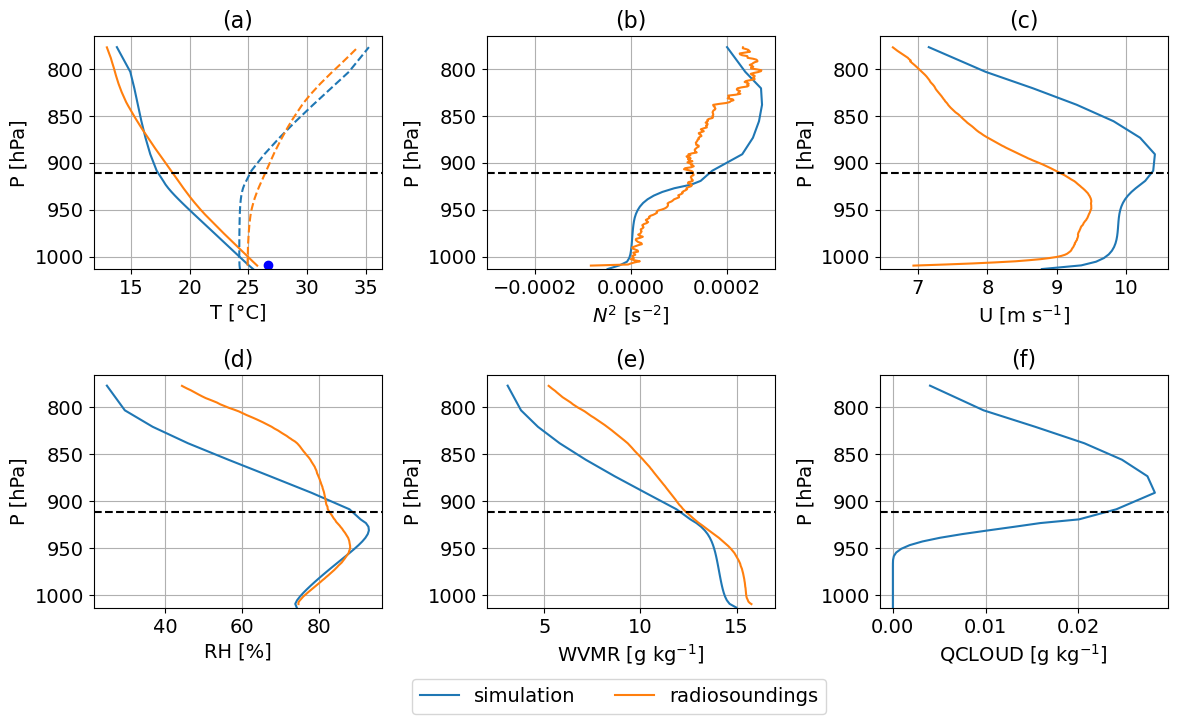

In [26]:
fig = plt.figure(figsize=(12,7))

import matplotlib
matplotlib.rcParams.update({'font.size': 14})

obs_lev_start = 5 # 50m
obs_lev_end = 230 # 2300m  ~776hPa

plt.subplot(2,3,1)
plt.plot(T_z - 273.15, GP, label = 'simulation')
plt.plot(ta_obs_z[obs_lev_start:obs_lev_end] - 273.15, p_obs_z[obs_lev_start:obs_lev_end], label = 'radiosoundings')
plt.plot(theta_z - 273.15, GP, color='tab:blue', linestyle = 'dashed')
plt.plot(theta_obs_z[obs_lev_start:obs_lev_end] - 273.15, p_obs_z[obs_lev_start:obs_lev_end], color='tab:orange', linestyle = 'dashed')
plt.axhline(PBLH_P, color = 'k', linestyle = 'dashed')
# plt.axvline(26.7, color = 'r', linestyle = 'dashed')
plt.plot(26.7,GP[1],'bo') 
plt.gca().invert_yaxis(); plt.grid(); plt.ylim(GP[0])
plt.xticks(np.arange(15,40,5))
plt.ylabel('P [hPa]'); plt.xlabel('T [°C]')
fig.legend(loc='lower center', bbox_to_anchor=(0.525, -0.05),bbox_transform=fig.transFigure, ncol=6)
# plt.text(25.3,790,'(a)', fontsize=16)
plt.title('(a)', fontsize=16)

plt.subplot(2,3,2)
plt.plot(N2_z, GP)
plt.plot(N2_obs_z[obs_lev_start:obs_lev_end], p_obs_z[obs_lev_start:obs_lev_end])
plt.axhline(PBLH_P, color = 'k', linestyle = 'dashed')
plt.gca().invert_yaxis(); plt.grid(); plt.ylim(GP[0]); plt.xlim(-3e-4, 3e-4)
plt.ylabel('P [hPa]'); plt.xlabel('$N^2$ [s$^{-2}$]')
# plt.text(1e-4,790,'(b)', fontsize=16)
plt.title('(b)', fontsize=16)

plt.subplot(2,3,3)
plt.plot(Utot_z, GP)
plt.plot(U_obs_z[obs_lev_start:obs_lev_end], p_obs_z[obs_lev_start:obs_lev_end])
plt.axhline(PBLH_P, color = 'k', linestyle = 'dashed')
plt.gca().invert_yaxis(); plt.grid(); plt.ylim(GP[0])
plt.xticks(np.arange(7,11))
plt.ylabel('P [hPa]'); plt.xlabel('U [m s$^{-1}$]')
# plt.text(10.1,790,'(c)', fontsize=16)
plt.title('(c)', fontsize=16)

plt.subplot(2,3,4)
plt.plot(rh_z, GP)
plt.plot(rh_obs_z[obs_lev_start:obs_lev_end], p_obs_z[obs_lev_start:obs_lev_end])
plt.axhline(PBLH_P, color = 'k', linestyle = 'dashed')
plt.gca().invert_yaxis(); plt.grid(); plt.ylim(GP[0])
plt.ylabel('P [hPa]'); plt.xlabel('RH [%]')
# plt.text(85,790,'(d)', fontsize=16)
plt.title('(d)', fontsize=16)

plt.subplot(2,3,5)
plt.plot(qvapor_z, GP)
plt.plot(mr_obs_z[obs_lev_start:obs_lev_end], p_obs_z[obs_lev_start:obs_lev_end])
plt.axhline(PBLH_P, color = 'k', linestyle = 'dashed')
plt.gca().invert_yaxis(); plt.grid(); plt.ylim(GP[0]); plt.xlim(2,17)
plt.ylabel('P [hPa]'); plt.xlabel('WVMR [g kg$^{-1}$]')
# plt.text(15.2,790,'(e)', fontsize=16)
plt.title('(e)', fontsize=16)

plt.subplot(2,3,6)
plt.plot(qcloud_z, GP)
plt.axhline(PBLH_P, color = 'k', linestyle = 'dashed')
plt.gca().invert_yaxis(); plt.grid(); plt.ylim(GP[0])
plt.ylabel('P [hPa]'); plt.xlabel('QCLOUD [g kg$^{-1}$]')
# plt.text(0.026,790,'(f)', fontsize=16)
plt.title('(f)', fontsize=16)

plt.tight_layout()